# Preparación inicial: Cargar los datos desde StatsBombPy

Primero, vamos a cargar los datos de la Euro 2024 usando StatsBombPy y preparar el DataFrame de eventos que utilizaremos para todos los gráficos.

In [2]:
%matplotlib notebook


In [2]:
from statsbombpy import sb
import pandas as pd

# Obtener los partidos de la Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Selecciona el primer partido como ejemplo
partido_id = partidos_euro_2024.iloc[0]['match_id']

# Obtener los eventos del partido
eventos = sb.events(match_id=partido_id)

# Ver las primeras filas del DataFrame
print(eventos.head())

/Users/marioruiz/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/marioruiz/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


  50_50 bad_behaviour_card ball_receipt_outcome block_deflection  \
0   NaN                NaN                  NaN              NaN   
1   NaN                NaN                  NaN              NaN   
2   NaN                NaN                  NaN              NaN   
3   NaN                NaN                  NaN              NaN   
4   NaN                NaN                  NaN              NaN   

  block_save_block carry_end_location clearance_aerial_won  \
0              NaN                NaN                  NaN   
1              NaN                NaN                  NaN   
2              NaN                NaN                  NaN   
3              NaN                NaN                  NaN   
4              NaN                NaN                  NaN   

  clearance_body_part clearance_head clearance_left_foot  ...  \
0                 NaN            NaN                 NaN  ...   
1                 NaN            NaN                 NaN  ...   
2                 NaN  

# 1. Desbordes y superación de defensores: Histograma del resultado de los duelos

Para este ejemplo, filtramos los eventos de tipo "Duel" y analizamos cuántos fueron ganados o perdidos utilizando un histograma.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar eventos de tipo "Duel"
duelos = eventos[eventos['type'] == 'Duel']

# Filtrar los duelos perdidos
duelos_perdidos = duelos[duelos['duel_outcome'] == 'Lost']

# Verificar los resultados de los duelos
print(duelos_perdidos['duel_outcome'].value_counts())


Series([], Name: count, dtype: int64)


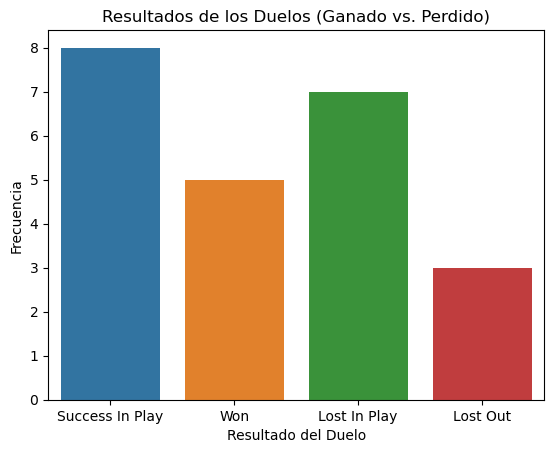

In [10]:
# Crear un histograma del resultado de los duelos
sns.countplot(x='duel_outcome', data=duelos)
plt.title('Resultados de los Duelos (Ganado vs. Perdido)')
plt.xlabel('Resultado del Duelo')
plt.ylabel('Frecuencia')
plt.show()


# 2. Ganancia de terreno del equipo rival: Distribución de metros ganados
Para este gráfico, vamos a medir cuántos metros ganó el equipo rival tras ganar un duelo. Calculamos la distancia entre la posición inicial y la final del pase.

In [4]:
# Verificar si las columnas 'location' y 'pass_end_location' tienen datos
print("Datos nulos en la columna 'location':", duelos_perdidos['location'].isnull().sum())
print("Datos nulos en la columna 'pass_end_location':", duelos_perdidos['pass_end_location'].isnull().sum())

# Verificar las primeras filas de estas columnas
print(duelos_perdidos[['location', 'pass_end_location']].head())


Datos nulos en la columna 'location': 0
Datos nulos en la columna 'pass_end_location': 0
Empty DataFrame
Columns: [location, pass_end_location]
Index: []


In [5]:
# Verificar qué tipos de eventos tienen 'pass_end_location'
eventos_con_ubicacion_final = eventos.dropna(subset=['pass_end_location'])
print(eventos_con_ubicacion_final['type'].unique())

# Revisar los primeros eventos con 'pass_end_location'
print(eventos_con_ubicacion_final[['type', 'location', 'pass_end_location']].head())



['Pass']
    type      location pass_end_location
6   Pass  [60.0, 40.0]      [25.7, 34.5]
7   Pass  [30.4, 24.1]      [89.2, 53.4]
8   Pass  [30.9, 26.7]      [59.4, 36.8]
9   Pass  [60.7, 43.3]      [85.1, 51.3]
10  Pass  [50.1, 16.3]      [37.1, 24.1]


In [6]:
# Filtrar eventos de tipo 'Pass' o 'Carry' que tienen ubicación final
eventos_validos = eventos[eventos['type'].isin(['Pass', 'Carry'])].dropna(subset=['pass_end_location'])

# Verificar que las columnas 'location' y 'pass_end_location' contengan listas de dos elementos
eventos_validos = eventos_validos[eventos_validos['location'].apply(lambda x: isinstance(x, list) and len(x) == 2)]
eventos_validos = eventos_validos[eventos_validos['pass_end_location'].apply(lambda x: isinstance(x, list) and len(x) == 2)]

# Mostrar las primeras filas de estos eventos
print(eventos_validos[['type', 'location', 'pass_end_location']].head())




    type      location pass_end_location
6   Pass  [60.0, 40.0]      [25.7, 34.5]
7   Pass  [30.4, 24.1]      [89.2, 53.4]
8   Pass  [30.9, 26.7]      [59.4, 36.8]
9   Pass  [60.7, 43.3]      [85.1, 51.3]
10  Pass  [50.1, 16.3]      [37.1, 24.1]


In [7]:
import numpy as np

# Calcular la distancia recorrida por el equipo tras el pase o carry
def calcular_ganancia_metros(row):
    loc_inicio = row['location']
    loc_final = row['pass_end_location']
    if isinstance(loc_inicio, list) and isinstance(loc_final, list):
        return np.sqrt((loc_final[0] - loc_inicio[0]) ** 2 + (loc_final[1] - loc_inicio[1]) ** 2)
    else:
        return np.nan

# Aplicar la función para calcular la ganancia de terreno
eventos_validos['ganancia_metros'] = eventos_validos.apply(calcular_ganancia_metros, axis=1)

# Mostrar los resultados
print(eventos_validos[['location', 'pass_end_location', 'ganancia_metros']].head())


        location pass_end_location  ganancia_metros
6   [60.0, 40.0]      [25.7, 34.5]        34.738163
7   [30.4, 24.1]      [89.2, 53.4]        65.695738
8   [30.9, 26.7]      [59.4, 36.8]        30.236733
9   [60.7, 43.3]      [85.1, 51.3]        25.678006
10  [50.1, 16.3]      [37.1, 24.1]        15.160475


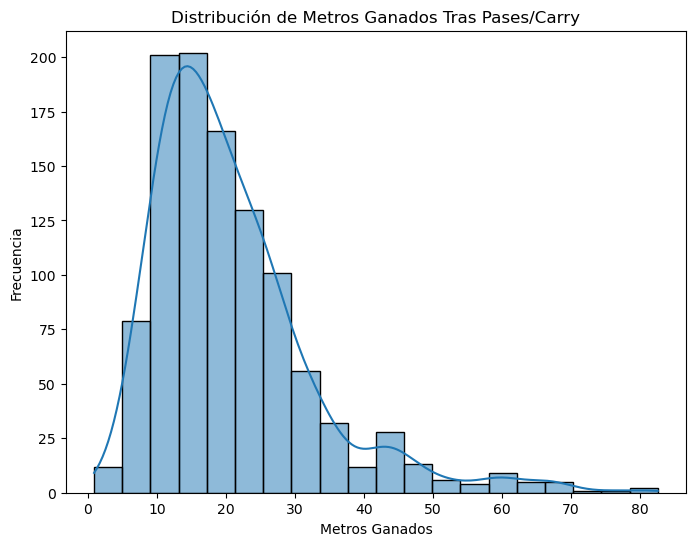

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Verificar si hay datos suficientes para graficar
if eventos_validos['ganancia_metros'].notnull().sum() > 0:
    # Crear el histograma de la ganancia de metros
    plt.figure(figsize=(8,6))
    sns.histplot(eventos_validos['ganancia_metros'], bins=20, kde=True)
    plt.title('Distribución de Metros Ganados Tras Pases/Carry')
    plt.xlabel('Metros Ganados')
    plt.ylabel('Frecuencia')
    plt.show()
else:
    print("No hay suficientes datos válidos para graficar la ganancia de metros.")


/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2035/1356902963.py:56: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coords, y=y_coords, weights=ganancia_metros, shade=True, cmap=cmap, ax=ax, alpha=0.6)


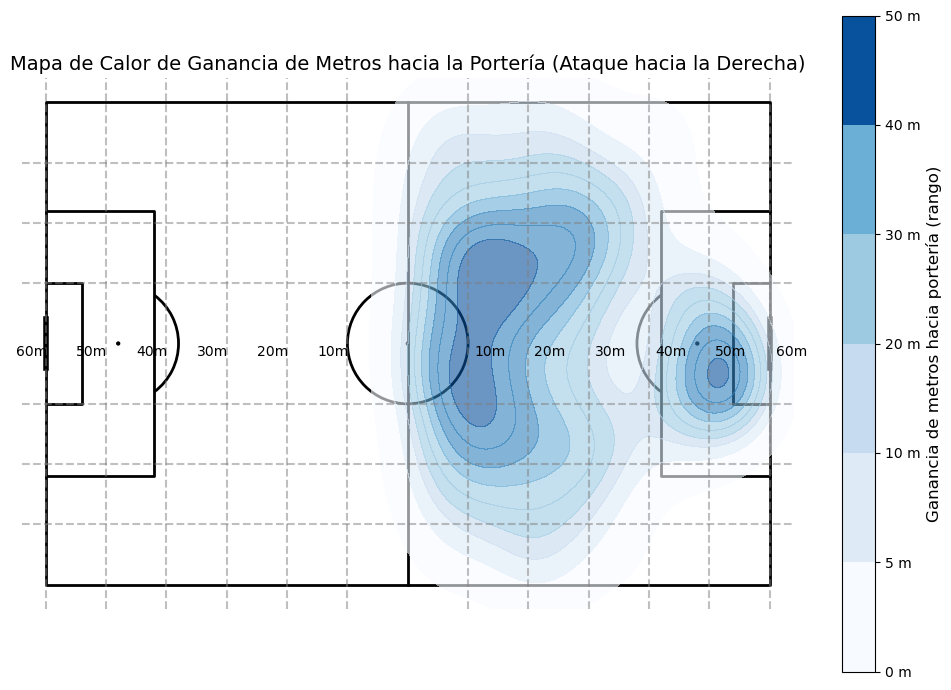

In [8]:
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Filtrar eventos de tipo 'Pass' o 'Carry' que tienen ubicación final
eventos_validos = eventos[eventos['type'].isin(['Pass', 'Carry'])].dropna(subset=['pass_end_location'])

# Verificar que las columnas 'location' y 'pass_end_location' contengan listas de dos elementos
eventos_validos = eventos_validos[eventos_validos['location'].apply(lambda x: isinstance(x, list) and len(x) == 2)]
eventos_validos = eventos_validos[eventos_validos['pass_end_location'].apply(lambda x: isinstance(x, list) and len(x) == 2)]

# Calcular la distancia recorrida por el equipo tras el pase o carry, pero solo si es hacia la portería rival
def calcular_ganancia_metros_hacia_porteria(row):
    loc_inicio = row['location']
    loc_final = row['pass_end_location']
    
    # Solo considerar eventos que muevan el balón hacia adelante (en dirección a la portería rival)
    if isinstance(loc_inicio, list) and isinstance(loc_final, list) and loc_final[0] > loc_inicio[0]:
        return np.sqrt((loc_final[0] - loc_inicio[0]) ** 2 + (loc_final[1] - loc_inicio[1]) ** 2)
    else:
        return 0  # No contar si el pase fue hacia atrás o lateral

# Aplicar la función para calcular la ganancia de terreno
eventos_validos['ganancia_metros_hacia_porteria'] = eventos_validos.apply(calcular_ganancia_metros_hacia_porteria, axis=1)

# Filtrar eventos que realmente ganaron metros hacia la portería
eventos_validos = eventos_validos[eventos_validos['ganancia_metros_hacia_porteria'] > 0]

# Ajustar las coordenadas para unificar la dirección de ataque (hacia la derecha)
eventos_validos['location_adjusted'] = eventos_validos['location'].apply(
    lambda x: [120 - x[0], x[1]] if x[0] < 60 else x  # Invertir X si el evento empieza en la mitad izquierda
)

eventos_validos['pass_end_location_adjusted'] = eventos_validos['pass_end_location'].apply(
    lambda x: [120 - x[0], x[1]] if x[0] < 60 else x  # Invertir X si el evento termina en la mitad izquierda
)

# Crear el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Extraer las ubicaciones ajustadas y la ganancia de metros hacia la portería
x_coords = eventos_validos['location_adjusted'].apply(lambda x: x[0])
y_coords = eventos_validos['location_adjusted'].apply(lambda x: x[1])
ganancia_metros = eventos_validos['ganancia_metros_hacia_porteria']

# Definir los límites de la ganancia de metros y los colores discretos
bins = [0, 5, 10, 20, 30, 40, 50]  # Límites de metros ganados
colors = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c']  # Colores para cada rango
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bins, cmap.N)

# Crear el mapa de calor basado en la ganancia de metros con colores discretos
sns.kdeplot(x=x_coords, y=y_coords, weights=ganancia_metros, shade=True, cmap=cmap, ax=ax, alpha=0.6)

# Crear la barra de color personalizada
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_ticks(bins)
cbar.set_ticklabels([f'{b} m' for b in bins])
cbar.set_label('Ganancia de metros hacia portería (rango)', fontsize=12)

# Añadir líneas de medición a partir del centro del campo
for i in range(10, 70, 10):
    ax.axvline(60 + i, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(60 - i, color='gray', linestyle='--', alpha=0.5)

# Añadir líneas horizontales cada 10 metros
for i in range(10, 40, 10):
    ax.axhline(40 + i, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(40 - i, color='gray', linestyle='--', alpha=0.5)

# Etiquetas de distancia desde el centro del campo
for i in range(10, 70, 10):
    ax.text(60 + i + 1, 42, f'{i}m', color='black', fontsize=10)
    ax.text(60 - i - 5, 42, f'{i}m', color='black', fontsize=10)

# Título del gráfico
plt.title('Mapa de Calor de Ganancia de Metros hacia la Portería (Ataque hacia la Derecha)', fontsize=14)
plt.show()


# 3. Zonas vulnerables del campo: Mapa de calor de ubicaciones de pases/tiros
Vamos a visualizar en el campo de fútbol las zonas donde el equipo rival realizó más pases o tiros, identificando las áreas más vulnerables.

/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2035/1437529693.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventos_validos['pass_end_location_adjusted'] = eventos_validos['pass_end_location'].apply(
/var/folders/w1/3ck7kf7d1vj6klf2d0r05f940000gn/T/ipykernel_2035/1437529693.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x_coords_end, y=y_coords_end, shade=True, cmap='coolwarm', ax=ax, shade_lowest=False, alpha=0.6)


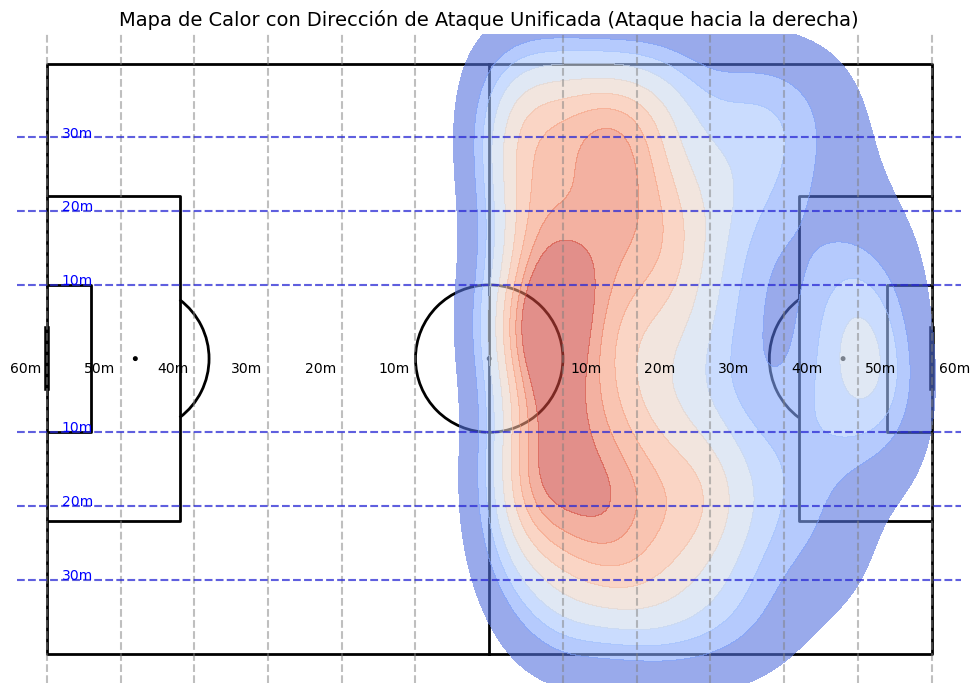

In [9]:
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Filtrar las filas donde 'pass_end_location' no es nulo
eventos_validos = eventos.dropna(subset=['pass_end_location'])

# Ajustar las coordenadas X para unificar la dirección de ataque hacia la derecha
# Invertir las coordenadas X si están en la mitad izquierda del campo
eventos_validos['pass_end_location_adjusted'] = eventos_validos['pass_end_location'].apply(
    lambda x: [120 - x[0], x[1]] if x[0] < 60 else x  # Invertir X si el pase termina en la mitad izquierda
)

# Extraer las posiciones finales de los pases/tiros ajustadas
x_coords_end = eventos_validos['pass_end_location_adjusted'].apply(lambda x: x[0])
y_coords_end = eventos_validos['pass_end_location_adjusted'].apply(lambda x: x[1])

# Crear el mapa de calor de las ubicaciones de los eventos hacia la misma dirección de ataque (derecha)
sns.kdeplot(x=x_coords_end, y=y_coords_end, shade=True, cmap='coolwarm', ax=ax, shade_lowest=False, alpha=0.6)

# Añadir líneas cada 10 metros a partir del centro del campo, cubriendo toda la longitud (120 metros)
for i in range(10, 70, 10):  # Desde el centro hacia las porterías
    ax.axvline(60 + i, color='gray', linestyle='--', alpha=0.5)  # Hacia la derecha
    ax.axvline(60 - i, color='gray', linestyle='--', alpha=0.5)  # Hacia la izquierda

# Añadir líneas horizontales cada 10 metros cubriendo todo el ancho (80 unidades en StatsBomb)
for i in range(10, 40, 10):  # Desde el centro hacia las bandas
    ax.axhline(40 + i, color='gray', linestyle='--', alpha=0.5)  # Hacia arriba
    ax.axhline(40 - i, color='gray', linestyle='--', alpha=0.5)  # Hacia abajo

# Añadir etiquetas de distancia desde el centro del campo
for i in range(10, 70, 10):
    ax.text(60 + i + 1, 42, f'{i}m', color='black', fontsize=10)
    ax.text(60 - i - 5, 42, f'{i}m', color='black', fontsize=10)

# Líneas horizontales desde el centro de las porterías hacia las esquinas (Y=0 a Y=80)
for i in range(10, 40, 10):  # Líneas desde la portería hacia las esquinas
    ax.axhline(40 + i, color='blue', linestyle='--', alpha=0.5)  # Hacia la derecha
    ax.axhline(40 - i, color='blue', linestyle='--', alpha=0.5)  # Hacia la izquierda

# Añadir etiquetas de distancia desde la portería hacia las bandas
for i in range(10, 40, 10):
    ax.text(2, 40 + i, f'{i}m', color='blue', fontsize=10)  # Distancias hacia la banda derecha
    ax.text(2, 40 - i, f'{i}m', color='blue', fontsize=10)  # Distancias hacia la banda izquierda

# Título del gráfico
plt.title('Mapa de Calor con Dirección de Ataque Unificada (Ataque hacia la derecha)', fontsize=14)
plt.show()


# 4. Peligrosidad de las zonas conquistadas: Scatter plot de Expected Goals (xG)

Finalmente, vamos a visualizar las ubicaciones de los tiros y el valor de Expected Goals (xG) para evaluar qué zonas son más peligrosas.

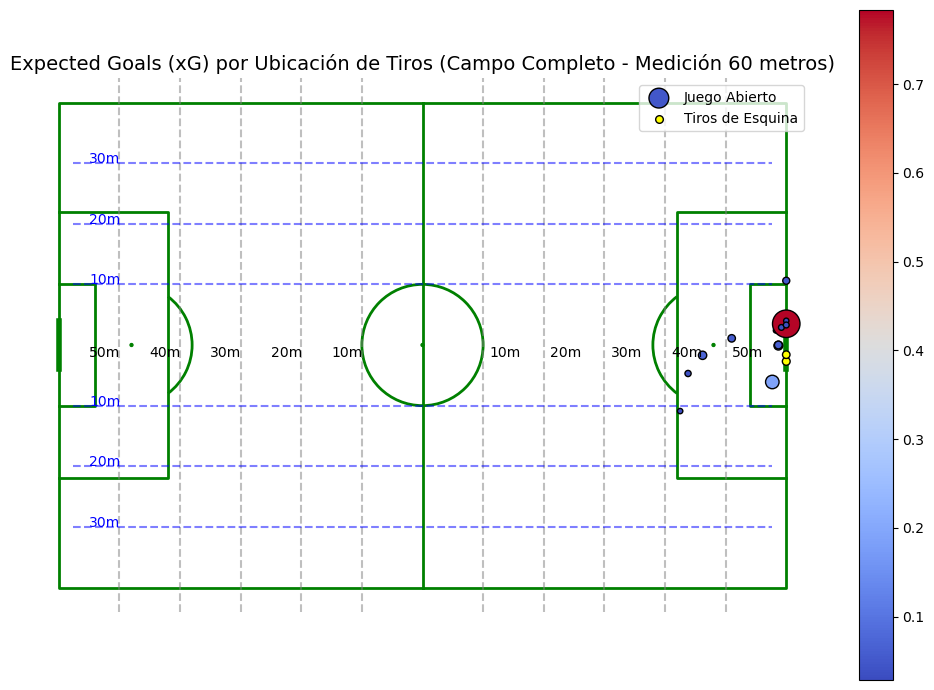

In [10]:
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar eventos de tipo 'Shot' y que tengan valores de xG
tiros_eventos = eventos[eventos['type'] == 'Shot']
tiros_eventos = tiros_eventos.dropna(subset=['shot_end_location', 'shot_statsbomb_xg'])

# Crear el campo de fútbol completo (sin 'half=True' para mostrar el campo completo)
pitch = Pitch(pitch_type='statsbomb', line_color='green')
fig, ax = pitch.draw(figsize=(10, 7))

# Filtrar tiros provenientes de un tiro de esquina ('From Corner')
tiros_corner = tiros_eventos[tiros_eventos['play_pattern'] == 'From Corner']

# Filtrar tiros en juego abierto ('Open Play') o cualquier otro patrón
tiros_juego_abierto = tiros_eventos[tiros_eventos['play_pattern'] != 'From Corner']

# Extraer las ubicaciones y los valores de xG para tiros de juego abierto
x_shots_abierto = tiros_juego_abierto['shot_end_location'].apply(lambda x: x[0])
y_shots_abierto = tiros_juego_abierto['shot_end_location'].apply(lambda x: x[1])
xg_values_abierto = tiros_juego_abierto['shot_statsbomb_xg']

# Extraer las ubicaciones y los valores de xG para tiros de esquina
x_shots_corner = tiros_corner['shot_end_location'].apply(lambda x: x[0])
y_shots_corner = tiros_corner['shot_end_location'].apply(lambda x: x[1])
xg_values_corner = tiros_corner['shot_statsbomb_xg']

# Dibujar los tiros de juego abierto (color basado en xG)
scatter_abierto = pitch.scatter(x_shots_abierto, y_shots_abierto, s=xg_values_abierto*500, 
                                c=xg_values_abierto, cmap='coolwarm', ax=ax, edgecolors='black', label='Juego Abierto')

# Dibujar los tiros de esquina (color amarillo)
scatter_corner = pitch.scatter(x_shots_corner, y_shots_corner, s=xg_values_corner*500, 
                               color='yellow', edgecolors='black', ax=ax, label='Tiros de Esquina')

# Añadir líneas de medición (solo 60 metros a partir del centro del campo hacia las porterías)
for i in range(10, 60, 10):
    ax.axvline(60 + i, color='gray', linestyle='--', alpha=0.5)  # Desde el centro hacia la derecha
    ax.axvline(60 - i, color='gray', linestyle='--', alpha=0.5)  # Desde el centro hacia la izquierda

# Añadir líneas laterales horizontales desde el centro de la portería hacia las esquinas del campo visible
for i in range(10, 40, 10):  # Medición solo dentro de la mitad del campo visible
    ax.axhline(40 + i, xmin=0.05, xmax=0.95, color='blue', linestyle='--', alpha=0.5)  # Hacia la derecha
    ax.axhline(40 - i, xmin=0.05, xmax=0.95, color='blue', linestyle='--', alpha=0.5)  # Hacia la izquierda

# Etiquetas de distancia desde el centro del campo (verticales)
for i in range(10, 60, 10):
    ax.text(60 + i + 1, 42, f'{i}m', color='black', fontsize=10)
    ax.text(60 - i - 5, 42, f'{i}m', color='black', fontsize=10)

# Etiquetas de distancia desde la portería hacia las bandas (horizontales)
for i in range(10, 40, 10):
    ax.text(5, 40 + i, f'{i}m', color='blue', fontsize=10)
    ax.text(5, 40 - i, f'{i}m', color='blue', fontsize=10)

# Añadir barra de color para los tiros de juego abierto (xG)
plt.colorbar(scatter_abierto)

# Añadir título y leyenda
plt.title('Expected Goals (xG) por Ubicación de Tiros (Campo Completo - Medición 60 metros)', fontsize=14)
ax.legend(loc='upper right')

plt.show()

In [13]:
# Imprimir los nombres de las columnas
print(eventos.columns)


Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'block_deflection', 'block_save_block', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_outcome', 'duel_outcome', 'duel_type', 'duration',
       'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_penalty', 'foul_won_advantage', 'foul_won_defensive',
       'foul_won_penalty', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_punched_out',
       'goalkeeper_technique', 'goalkeeper_type', 'id', 'index',
       'injury_stoppage_in_chain', 'interception_outcome', 'location',
       'match_id', 'minute', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assis

In [14]:
import random

# Seleccionamos un partido al azar
partido_aleatorio = random.choice(eventos['match_id'].unique())

# Filtrar los eventos de ese partido y del primer tiempo (primeros 45 minutos)
eventos_partido = eventos[(eventos['match_id'] == partido_aleatorio) & (eventos['period'] == 1)]

# Obtener los equipos que jugaron ese partido
equipos = eventos_partido['team'].unique()

# Obtener la lista de jugadores por equipo
jugadores_equipo1 = eventos_partido[eventos_partido['team'] == equipos[0]]['player'].unique()
jugadores_equipo2 = eventos_partido[eventos_partido['team'] == equipos[1]]['player'].unique()

# Filtrar las sustituciones (eventos de tipo 'Substitution') que ocurrieron en el primer tiempo
cambios_equipo1 = eventos_partido[(eventos_partido['team'] == equipos[0]) & (eventos_partido['type'] == 'Substitution')]
cambios_equipo2 = eventos_partido[(eventos_partido['team'] == equipos[1]) & (eventos_partido['type'] == 'Substitution')]

# Imprimir la información del partido
print(f"Partido seleccionado: {partido_aleatorio}")
print(f"Equipos: {equipos[0]} vs {equipos[1]}")

# Imprimir los jugadores del primer equipo
print(f"\nJugadores del {equipos[0]} en el primer tiempo:")
for jugador in jugadores_equipo1:
    print(f" - {jugador}")

# Imprimir los cambios del primer equipo (si los hubo)
if not cambios_equipo1.empty:
    print(f"\nCambios en el {equipos[0]} en el primer tiempo:")
    for index, row in cambios_equipo1.iterrows():
        print(f" - {row['player']} fue sustituido por {row['substitution_replacement']} al minuto {row['minute']}")
else:
    print(f"\nNo hubo cambios en el {equipos[0]} en el primer tiempo.")

# Imprimir los jugadores del segundo equipo
print(f"\nJugadores del {equipos[1]} en el primer tiempo:")
for jugador in jugadores_equipo2:
    print(f" - {jugador}")

# Imprimir los cambios del segundo equipo (si los hubo)
if not cambios_equipo2.empty:
    print(f"\nCambios en el {equipos[1]} en el primer tiempo:")
    for index, row in cambios_equipo2.iterrows():
        print(f" - {row['player']} fue sustituido por {row['substitution_replacement']} al minuto {row['minute']}")
else:
    print(f"\nNo hubo cambios en el {equipos[1]} en el primer tiempo.")


Partido seleccionado: 3942819
Equipos: Netherlands vs England

Jugadores del Netherlands en el primer tiempo:
 - nan
 - Virgil van Dijk
 - Nathan Aké
 - Stefan de Vrij
 - Jerdy Schouten
 - Denzel Dumfries
 - Bart Verbruggen
 - Memphis Depay
 - Xavi Simons
 - Tijjani Reijnders
 - Donyell Malen
 - Cody Mathès Gakpo
 - Joey Veerman

Cambios en el Netherlands en el primer tiempo:
 - Memphis Depay fue sustituido por Joey Veerman al minuto 34

Jugadores del England en el primer tiempo:
 - nan
 - Kobbie Mainoo
 - Jordan Pickford
 - John Stones
 - Marc Guehi
 - Declan Rice
 - Jude Bellingham
 - Kieran Trippier
 - Phil Foden
 - Kyle Walker
 - Bukayo Saka
 - Harry Kane

No hubo cambios en el England en el primer tiempo.


In [29]:
from statsbombpy import sb

# Obtener partidos de una competición válida (por ejemplo, Euro 2020)
partidos = sb.matches(competition_id=55, season_id=43)

# Mostrar algunos partidos para elegir un match_id válido
print(partidos[['match_id', 'home_team', 'away_team', 'kick_off']].head())

# Escoge un match_id válido de la salida que veas en el print


   match_id    home_team away_team      kick_off
0   3795108  Switzerland     Spain  18:00:00.000
1   3788769       Russia   Denmark  21:00:00.000
2   3788766        Italy     Wales  18:00:00.000
3   3795220        Italy     Spain  21:00:00.000
4   3788761       Sweden  Slovakia  15:00:00.000


In [4]:
from statsbombpy import sb

# Definir el ID del partido válido
match_id = 3788769  # Reemplaza con el match_id válido

# Extraer las alineaciones del partido
alineaciones = sb.lineups(match_id)

# Recorrer las alineaciones de cada equipo
for equipo, datos in alineaciones.items():
    print(f"\nEquipo: {equipo}")
    print("Alineación inicial:")
    
    # Dado que las posiciones están dentro de una lista de diccionarios en la columna 'positions'
    for index, row in datos.iterrows():
        # Extraer la primera posición de la lista si está disponible
        if row['positions']:  # Verificar que la lista no esté vacía
            posicion = row['positions'][0]['position']  # Obtener la primera posición de la lista
        else:
            posicion = 'Sin posición'
        
        print(f"Jugador: {row['player_name']} - Posición: {posicion}")



Equipo: Denmark
Alineación inicial:
Jugador: Mathias Jattah-Njie Jørgensen - Posición: Sin posición
Jugador: Jonas Lössl - Posición: Sin posición
Jugador: Pierre-Emile Højbjerg - Posición: Right Defensive Midfield
Jugador: Kasper Schmeichel - Posición: Goalkeeper
Jugador: Andreas Christensen - Posición: Right Center Back
Jugador: Martin Braithwaite Christensen - Posición: Right Attacking Midfield
Jugador: Jens Stryger Larsen - Posición: Right Wing Back
Jugador: Thomas Delaney - Posición: Left Defensive Midfield
Jugador: Simon Thorup Kjær - Posición: Center Back
Jugador: Yussuf Yurary Poulsen - Posición: Center Forward
Jugador: Andreas Evald Cornelius - Posición: Right Attacking Midfield
Jugador: Kasper Dolberg - Posición: Center Forward
Jugador: Daniel Wass - Posición: Right Wing Back
Jugador: Christian Nørgaard - Posición: Left Attacking Midfield
Jugador: Joachim Andersen - Posición: Sin posición
Jugador: Jannik Vestergaard - Posición: Left Center Back
Jugador: Frederik Rønnow - Posi

/Users/marioruiz/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(



Graficando alineación del equipo: Denmark


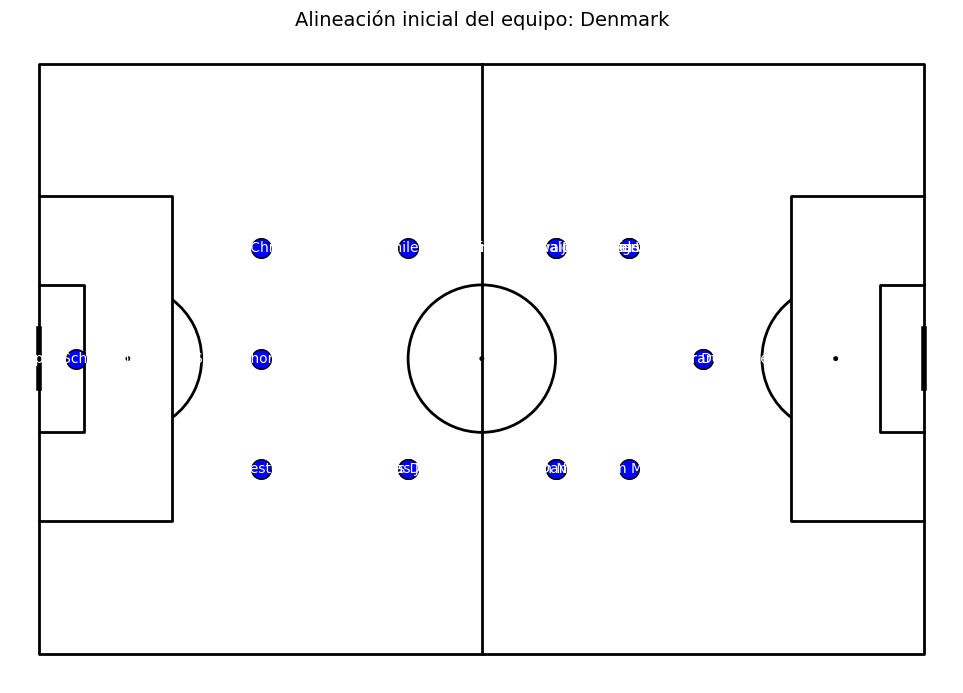


Graficando alineación del equipo: Russia


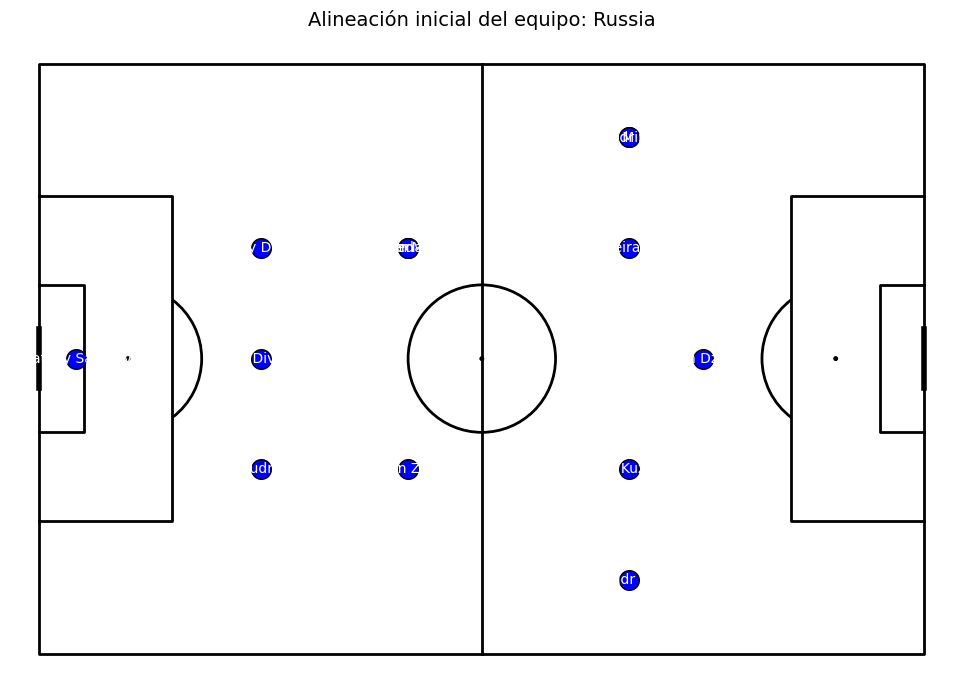

In [5]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from statsbombpy import sb

# Definir el ID del partido válido
match_id = 3788769  # Reemplaza con el match_id válido

# Extraer las alineaciones del partido
alineaciones = sb.lineups(match_id)

# Función para graficar la alineación de un equipo
def graficar_alineacion_equipo(equipo, datos):
    # Crear el campo de fútbol
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))
    
    # Dibujar a los jugadores en sus posiciones si la posición está disponible
    for index, row in datos.iterrows():
        if row['positions']:  # Verificar si el jugador tiene posiciones disponibles
            posicion = row['positions'][0]['position']  # Primera posición disponible
            # Asignar coordenadas aproximadas (esto depende del tipo de posición)
            # Ejemplo: Definir algunas coordenadas para posiciones comunes (esto se puede ajustar)
            posicion_coordenadas = {
                'Goalkeeper': [5, 40], 
                'Center Forward': [90, 40],
                'Right Defensive Midfield': [50, 25],
                'Left Defensive Midfield': [50, 55],
                'Right Wing Back': [80, 25],
                'Left Wing Back': [80, 55],
                'Right Center Back': [30, 25],
                'Left Center Back': [30, 55],
                'Center Back': [30, 40],
                'Right Attacking Midfield': [70, 25],
                'Left Attacking Midfield': [70, 55],
                'Right Wing': [80, 10],
                'Left Wing': [80, 70]
            }
            
            # Obtener las coordenadas de la posición
            coords = posicion_coordenadas.get(posicion, None)
            
            if coords:  # Solo graficar si las coordenadas están definidas
                ax.scatter(coords[0], coords[1], c='blue', s=200, edgecolors='black')
                ax.text(coords[0], coords[1], row['player_name'], fontsize=10, ha='center', va='center', color='white')
    
    # Añadir el título
    ax.set_title(f'Alineación inicial del equipo: {equipo}', fontsize=14)
    plt.show()

# Graficar la alineación del primer equipo
for equipo, datos in alineaciones.items():
    print(f"\nGraficando alineación del equipo: {equipo}")
    graficar_alineacion_equipo(equipo, datos)


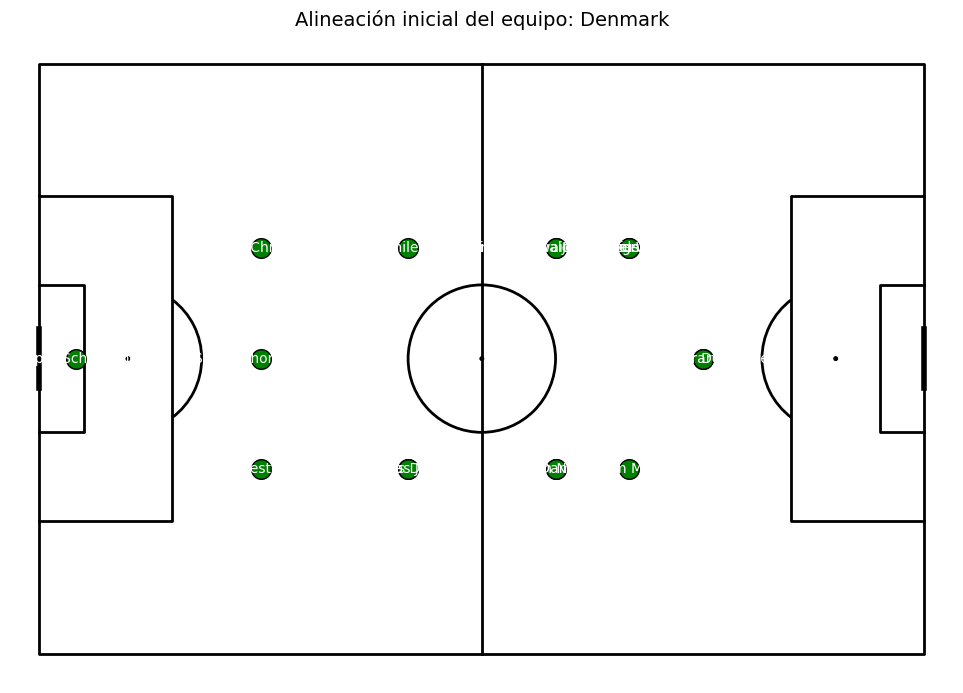

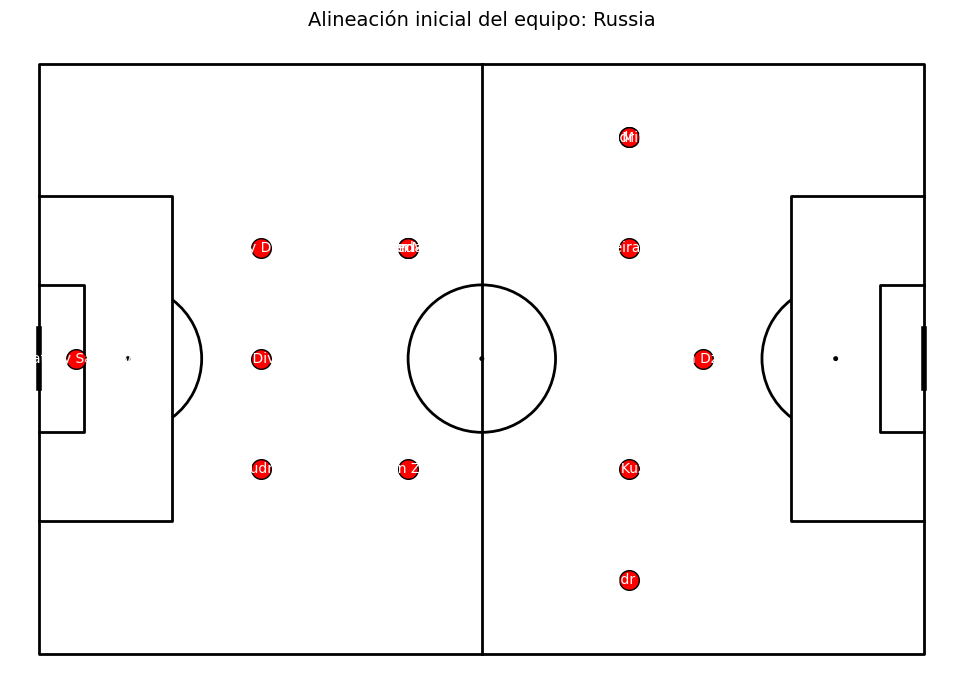

In [7]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from statsbombpy import sb

# Definir el ID del partido válido
match_id = 3788769  # Reemplaza con el match_id válido

# Extraer las alineaciones del partido
alineaciones = sb.lineups(match_id)

# Función para graficar la alineación de un equipo con color
def graficar_alineacion_equipo(equipo, datos, color):
    # Crear el campo de fútbol
    pitch = Pitch(pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))
    
    # Dibujar a los jugadores en sus posiciones si la posición está disponible
    for index, row in datos.iterrows():
        if row['positions']:  # Verificar si el jugador tiene posiciones disponibles
            posicion = row['positions'][0]['position']  # Primera posición disponible
            # Asignar coordenadas aproximadas (esto depende del tipo de posición)
            posicion_coordenadas = {
                'Goalkeeper': [5, 40], 
                'Center Forward': [90, 40],
                'Right Defensive Midfield': [50, 25],
                'Left Defensive Midfield': [50, 55],
                'Right Wing Back': [80, 25],
                'Left Wing Back': [80, 55],
                'Right Center Back': [30, 25],
                'Left Center Back': [30, 55],
                'Center Back': [30, 40],
                'Right Attacking Midfield': [70, 25],
                'Left Attacking Midfield': [70, 55],
                'Right Wing': [80, 10],
                'Left Wing': [80, 70]
            }
            
            # Obtener las coordenadas de la posición
            coords = posicion_coordenadas.get(posicion, None)
            
            if coords:  # Solo graficar si las coordenadas están definidas
                ax.scatter(coords[0], coords[1], c=color, s=200, edgecolors='black')
                ax.text(coords[0], coords[1], row['player_name'], fontsize=10, ha='center', va='center', color='white')
    
    # Añadir el título
    ax.set_title(f'Alineación inicial del equipo: {equipo}', fontsize=14)
    plt.show()

# Graficar la alineación del primer equipo (en verde) y el segundo equipo (en rojo)
for i, (equipo, datos) in enumerate(alineaciones.items()):
    if i == 0:
        graficar_alineacion_equipo(equipo, datos, 'green')  # Primer equipo en verde
    else:
        graficar_alineacion_equipo(equipo, datos, 'red')  # Segundo equipo en rojo


In [26]:
from statsbombpy import sb

# Definir el ID del partido válido
match_id = 3942226  # Usar el ID actualizado

# Obtener los eventos del partido
eventos = sb.events(match_id=match_id)

# Filtrar los eventos del primer tiempo
eventos_primer_tiempo = eventos[eventos['period'] == 1]

# Filtrar las sustituciones y cambios tácticos
sustituciones = eventos_primer_tiempo[eventos_primer_tiempo['type'] == 'Substitution']
cambios_tacticos = eventos_primer_tiempo[eventos_primer_tiempo['type'] == 'Tactics']  # Revisar si hay eventos tácticos

# Contar cuántas sustituciones y cambios tácticos ocurrieron en el primer tiempo
num_sustituciones = len(sustituciones)
num_cambios_tacticos = len(cambios_tacticos)

# Mostrar los resultados
print(f"En el primer tiempo hubo {num_sustituciones} sustituciones.")
print(f"En el primer tiempo hubo {num_cambios_tacticos} cambios tácticos.")


En el primer tiempo hubo 1 sustituciones.
En el primer tiempo hubo 0 cambios tácticos.


In [21]:
from statsbombpy import sb

# Definir el ID del partido válido
match_id = 3795108  # Usar el ID actualizado

# Obtener los eventos del partido
eventos = sb.events(match_id=match_id)

# Filtrar los eventos del segundo tiempo
eventos_segundo_tiempo = eventos[eventos['period'] == 1]

# Filtrar las sustituciones en el segundo tiempo
sustituciones_segundo_tiempo = eventos_segundo_tiempo[eventos_segundo_tiempo['type'] == 'Substitution']

# Mostrar detalles de las sustituciones (qué equipo, qué jugador salió, quién entró y en qué minuto)
for index, row in sustituciones_segundo_tiempo.iterrows():
    equipo = row['team']
    jugador_sustituido = row['player']  # Jugador que salió
    jugador_entrante = row['substitution_replacement']  # Jugador que entró
    minuto = row['minute']  # Minuto en que ocurrió la sustitución

    print(f"Equipo: {equipo}")
    print(f"Sustitución: {jugador_sustituido} fue sustituido por {jugador_entrante} en el minuto {minuto}")
    print("-" * 40)


Equipo: Switzerland
Sustitución: Breel-Donald Embolo fue sustituido por Ruben Vargas en el minuto 22
----------------------------------------


In [24]:
from statsbombpy import sb

# Obtener todos los partidos del torneo Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Función para verificar si hubo cambios de alineación en un partido
def verificar_cambios_alineacion(match_id):
    # Obtener los eventos del partido
    eventos = sb.events(match_id=match_id)
    
    # Filtrar los eventos del primer y segundo tiempo
    eventos_primer_tiempo = eventos[eventos['period'] == 1]
    eventos_segundo_tiempo = eventos[eventos['period'] == 2]
    
    # Buscar sustituciones en ambos tiempos
    sustituciones_primer_tiempo = eventos_primer_tiempo[eventos_primer_tiempo['type'] == 'Substitution']
    sustituciones_segundo_tiempo = eventos_segundo_tiempo[eventos_segundo_tiempo['type'] == 'Substitution']
    
    # Verificar si hubo sustituciones en el primer o segundo tiempo
    cambios_primer_tiempo = len(sustituciones_primer_tiempo) > 0
    cambios_segundo_tiempo = len(sustituciones_segundo_tiempo) > 0
    
    return cambios_primer_tiempo, cambios_segundo_tiempo

# Recorrer todos los partidos y verificar si hubo cambios de alineación
resultados_cambios = []

for index, partido in partidos_euro_2024.iterrows():
    match_id = partido['match_id']
    home_team = partido['home_team']
    away_team = partido['away_team']
    
    # Verificar si hubo cambios de alineación en el partido
    cambios_primer_tiempo, cambios_segundo_tiempo = verificar_cambios_alineacion(match_id)
    
    if cambios_primer_tiempo or cambios_segundo_tiempo:
        resultados_cambios.append({
            'match_id': match_id,
            'home_team': home_team,
            'away_team': away_team,
            'cambios_primer_tiempo': cambios_primer_tiempo,
            'cambios_segundo_tiempo': cambios_segundo_tiempo
        })

# Mostrar los resultados
for resultado in resultados_cambios:
    print(f"Match ID: {resultado['match_id']}")
    print(f"Partido: {resultado['home_team']} vs {resultado['away_team']}")
    if resultado['cambios_primer_tiempo']:
        print("  Hubo cambios en el primer tiempo")
    if resultado['cambios_segundo_tiempo']:
        print("  Hubo cambios en el segundo tiempo")
    print("-" * 40)


Match ID: 3942819
Partido: Netherlands vs England
  Hubo cambios en el primer tiempo
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3943043
Partido: Spain vs England
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3942752
Partido: Spain vs France
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3942382
Partido: Netherlands vs Turkey
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3942349
Partido: Portugal vs France
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3930180
Partido: Netherlands vs Austria
  Hubo cambios en el primer tiempo
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3930171
Partido: Denmark vs England
  Hubo cambios en el segundo tiempo
----------------------------------------
Match ID: 3942227
Partido: England vs Switzerland
  Hubo cambio

In [28]:
from statsbombpy import sb

# Obtener todos los partidos del torneo Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Función para verificar si hubo cambios tácticos en un partido
def verificar_cambios_tacticos(match_id):
    # Obtener los eventos del partido
    eventos = sb.events(match_id=match_id)
    
    # Filtrar los eventos tácticos
    eventos_tacticos = eventos[eventos['type'] == 'Tactics']
    
    # Verificar si hay más de un evento táctico por equipo
    formaciones_por_equipo = {}
    
    for index, row in eventos_tacticos.iterrows():
        equipo = row['team']
        formacion = row['tactics']['formation']  # Obtener la formación táctica
        if equipo not in formaciones_por_equipo:
            formaciones_por_equipo[equipo] = []
        formaciones_por_equipo[equipo].append(formacion)
    
    # Verificar si un equipo cambió su formación
    cambios_tacticos = {}
    for equipo, formaciones in formaciones_por_equipo.items():
        if len(set(formaciones)) > 1:  # Si hay más de una formación distinta
            cambios_tacticos[equipo] = formaciones
    
    return cambios_tacticos

# Recorrer todos los partidos y verificar si hubo cambios tácticos
resultados_cambios_tacticos = []

for index, partido in partidos_euro_2024.iterrows():
    match_id = partido['match_id']
    home_team = partido['home_team']
    away_team = partido['away_team']
    
    # Verificar si hubo cambios tácticos en el partido
    cambios_tacticos = verificar_cambios_tacticos(match_id)
    
    if cambios_tacticos:
        resultados_cambios_tacticos.append({
            'match_id': match_id,
            'home_team': home_team,
            'away_team': away_team,
            'cambios_tacticos': cambios_tacticos
        })

# Mostrar los resultados
for resultado in resultados_cambios_tacticos:
    print(f"Match ID: {resultado['match_id']}")
    print(f"Partido: {resultado['home_team']} vs {resultado['away_team']}")
    for equipo, formaciones in resultado['cambios_tacticos'].items():
        print(f"  Equipo: {equipo}")
        print(f"  Formaciones durante el partido: {formaciones}")
        print("  Hubo cambios en la alineación táctica")
    print("-" * 40)


In [29]:
from statsbombpy import sb

# Obtener todos los partidos del torneo Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Seleccionar un partido al azar para inspeccionar los tipos de eventos
match_id = partidos_euro_2024.iloc[0]['match_id']  # Escoge un partido al azar

# Obtener los eventos del partido
eventos = sb.events(match_id=match_id)

# Mostrar los tipos de eventos disponibles en este partido
print("Tipos de eventos en este partido:")
print(eventos['type'].unique())


Tipos de eventos en este partido:
['Starting XI' 'Half Start' 'Pass' 'Ball Receipt*' 'Carry' 'Pressure'
 'Miscontrol' 'Ball Recovery' 'Foul Committed' 'Foul Won' 'Dribbled Past'
 'Dribble' 'Block' 'Interception' 'Duel' 'Goal Keeper' 'Clearance'
 'Dispossessed' 'Shot' 'Injury Stoppage' 'Player Off' 'Player On'
 'Referee Ball-Drop' '50/50' 'Substitution' 'Tactical Shift' 'Half End'
 'Bad Behaviour']


In [31]:
from statsbombpy import sb

# Obtener todos los partidos del torneo Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Función para verificar si hubo cambios tácticos en un partido y los minutos
def verificar_cambios_tacticos_con_minutos(match_id):
    # Obtener los eventos del partido
    eventos = sb.events(match_id=match_id)
    
    # Filtrar los eventos tácticos con "Tactical Shift"
    eventos_tacticos = eventos[eventos['type'] == 'Tactical Shift']
    
    # Verificar si hay más de un evento táctico por equipo
    formaciones_por_equipo = {}
    
    for index, row in eventos_tacticos.iterrows():
        equipo = row['team']
        minuto = row['minute']  # Minuto en que ocurrió el cambio táctico
        if 'tactics' in row and 'formation' in row['tactics']:  # Verificar que la formación esté disponible
            formacion = row['tactics']['formation']  # Obtener la formación táctica
            if equipo not in formaciones_por_equipo:
                formaciones_por_equipo[equipo] = []
            formaciones_por_equipo[equipo].append((formacion, minuto))
    
    # Verificar si un equipo cambió su formación
    cambios_tacticos = {}
    for equipo, formaciones in formaciones_por_equipo.items():
        if len(set(f[0] for f in formaciones)) > 1:  # Si hay más de una formación distinta
            cambios_tacticos[equipo] = formaciones
    
    return cambios_tacticos

# Recorrer todos los partidos y verificar si hubo cambios tácticos
resultados_cambios_tacticos = []

for index, partido in partidos_euro_2024.iterrows():
    match_id = partido['match_id']
    home_team = partido['home_team']
    away_team = partido['away_team']
    
    # Verificar si hubo cambios tácticos en el partido
    cambios_tacticos = verificar_cambios_tacticos_con_minutos(match_id)
    
    if cambios_tacticos:
        resultados_cambios_tacticos.append({
            'match_id': match_id,
            'home_team': home_team,
            'away_team': away_team,
            'cambios_tacticos': cambios_tacticos
        })

# Mostrar los resultados con los minutos de los cambios tácticos
for resultado in resultados_cambios_tacticos:
    print(f"Match ID: {resultado['match_id']}")
    print(f"Partido: {resultado['home_team']} vs {resultado['away_team']}")
    for equipo, formaciones in resultado['cambios_tacticos'].items():
        print(f"  Equipo: {equipo}")
        print(f"  Formaciones durante el partido y sus minutos:")
        for formacion, minuto in formaciones:
            print(f"    Formación: {formacion} en el minuto {minuto}")
        print("  Hubo cambios en la alineación táctica")
    print("-" * 40)


Match ID: 3943043
Partido: Spain vs England
  Equipo: England
  Formaciones durante el partido y sus minutos:
    Formación: 4231 en el minuto 69
    Formación: 41212 en el minuto 89
  Hubo cambios en la alineación táctica
----------------------------------------
Match ID: 3942752
Partido: Spain vs France
  Equipo: Spain
  Formaciones durante el partido y sus minutos:
    Formación: 4231 en el minuto 57
    Formación: 433 en el minuto 93
  Hubo cambios en la alineación táctica
  Equipo: France
  Formaciones durante el partido y sus minutos:
    Formación: 4231 en el minuto 62
    Formación: 442 en el minuto 78
  Hubo cambios en la alineación táctica
----------------------------------------
Match ID: 3942382
Partido: Netherlands vs Turkey
  Equipo: Netherlands
  Formaciones durante el partido y sus minutos:
    Formación: 4231 en el minuto 45
    Formación: 4411 en el minuto 87
  Hubo cambios en la alineación táctica
----------------------------------------
Match ID: 3942349
Partido: Po

In [34]:
pip install mplsoccer matplotlib


Note: you may need to restart the kernel to use updated packages.


<IPython.core.display.Javascript object>


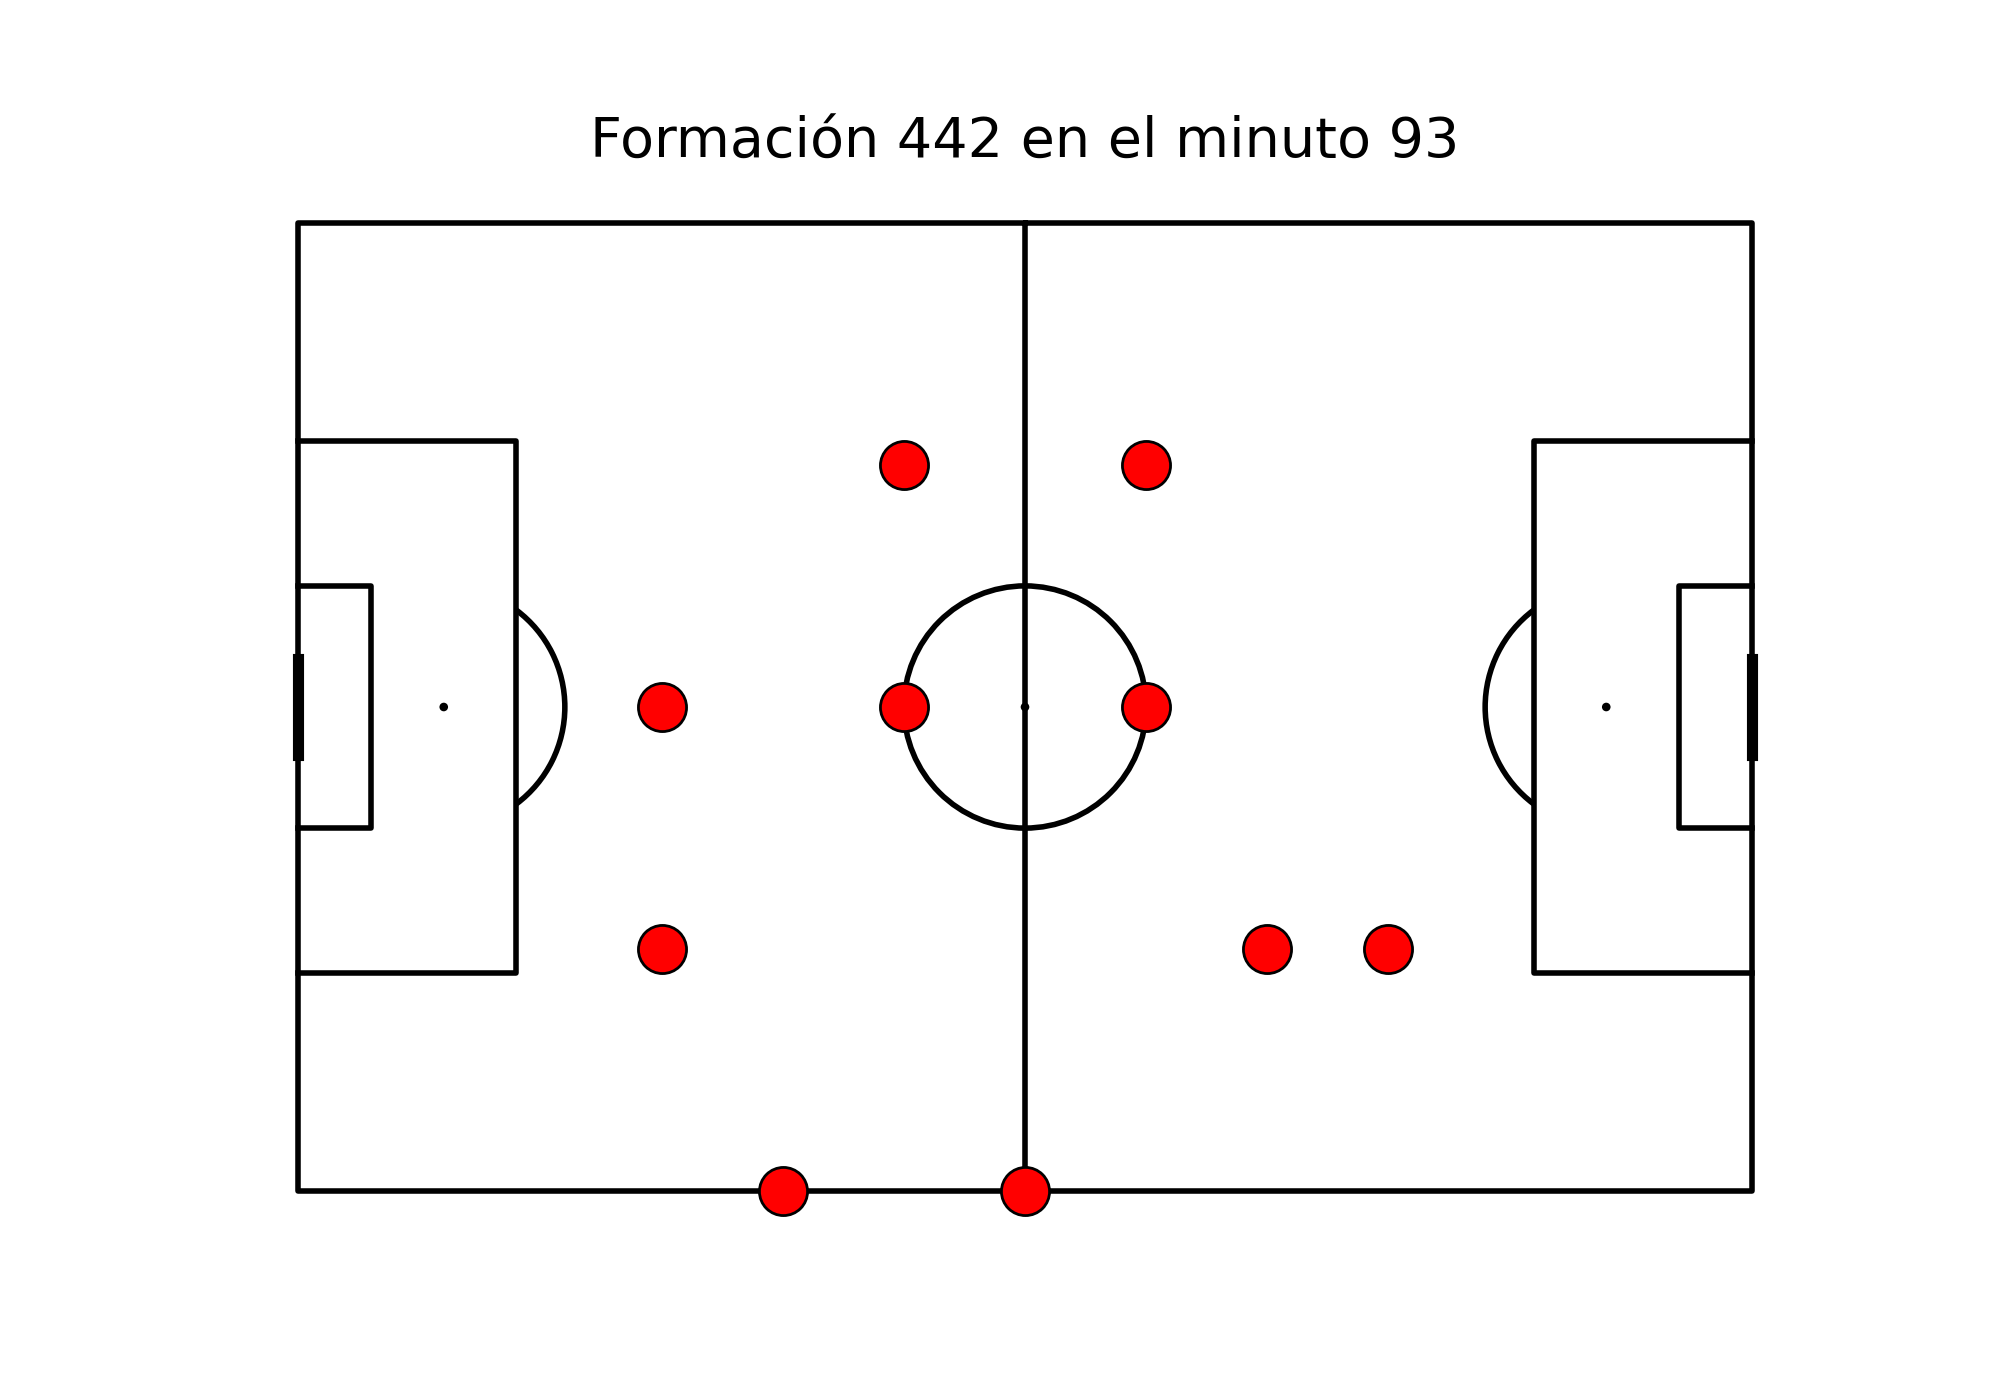

In [9]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.animation import FuncAnimation

# Definir los cambios de formación y los minutos en los que ocurren
formaciones = [
    (4231, 65),
    (4231, 83),
    (442, 93),
    (352, 90),
    (343, 105)
]

# Crear una lista simulada de posiciones de jugadores para cada formación
posiciones_formaciones = {
    4231: [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (60, 20), (40, 20), (80, 20)],
    442:  [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (50, 20), (70, 20)],
    352:  [(20, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (60, 20), (40, 20), (80, 20)],
    343:  [(20, 60), (40, 80), (60, 80), (80, 60), (50, 50), (30, 40), (70, 40), (60, 20), (50, 30), (40, 20), (80, 20)]
}

# Crear el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Función para dibujar cada cuadro de la animación
def actualizar_formacion(frame):
    ax.clear()  # Limpiar el eje para cada nueva formación
    pitch.draw(ax=ax)  # Redibujar el campo
    formacion, minuto = formaciones[frame]  # Obtener la formación y el minuto actual
    posiciones = posiciones_formaciones[formacion]  # Obtener las posiciones para la formación
    
    # Dibujar los jugadores en sus posiciones
    for pos in posiciones:
        ax.scatter(pos[0], pos[1], color='red', s=300, edgecolors='black', zorder=5)
    
    # Añadir un título con la formación y el minuto
    ax.set_title(f"Formación {formacion} en el minuto {minuto}", fontsize=20)

# Crear la animación con repetición infinita
anim = FuncAnimation(fig, actualizar_formacion, frames=len(formaciones), interval=2000, repeat=True)

# Mostrar la animación
plt.show()


In [4]:
%matplotlib notebook


<IPython.core.display.Javascript object>


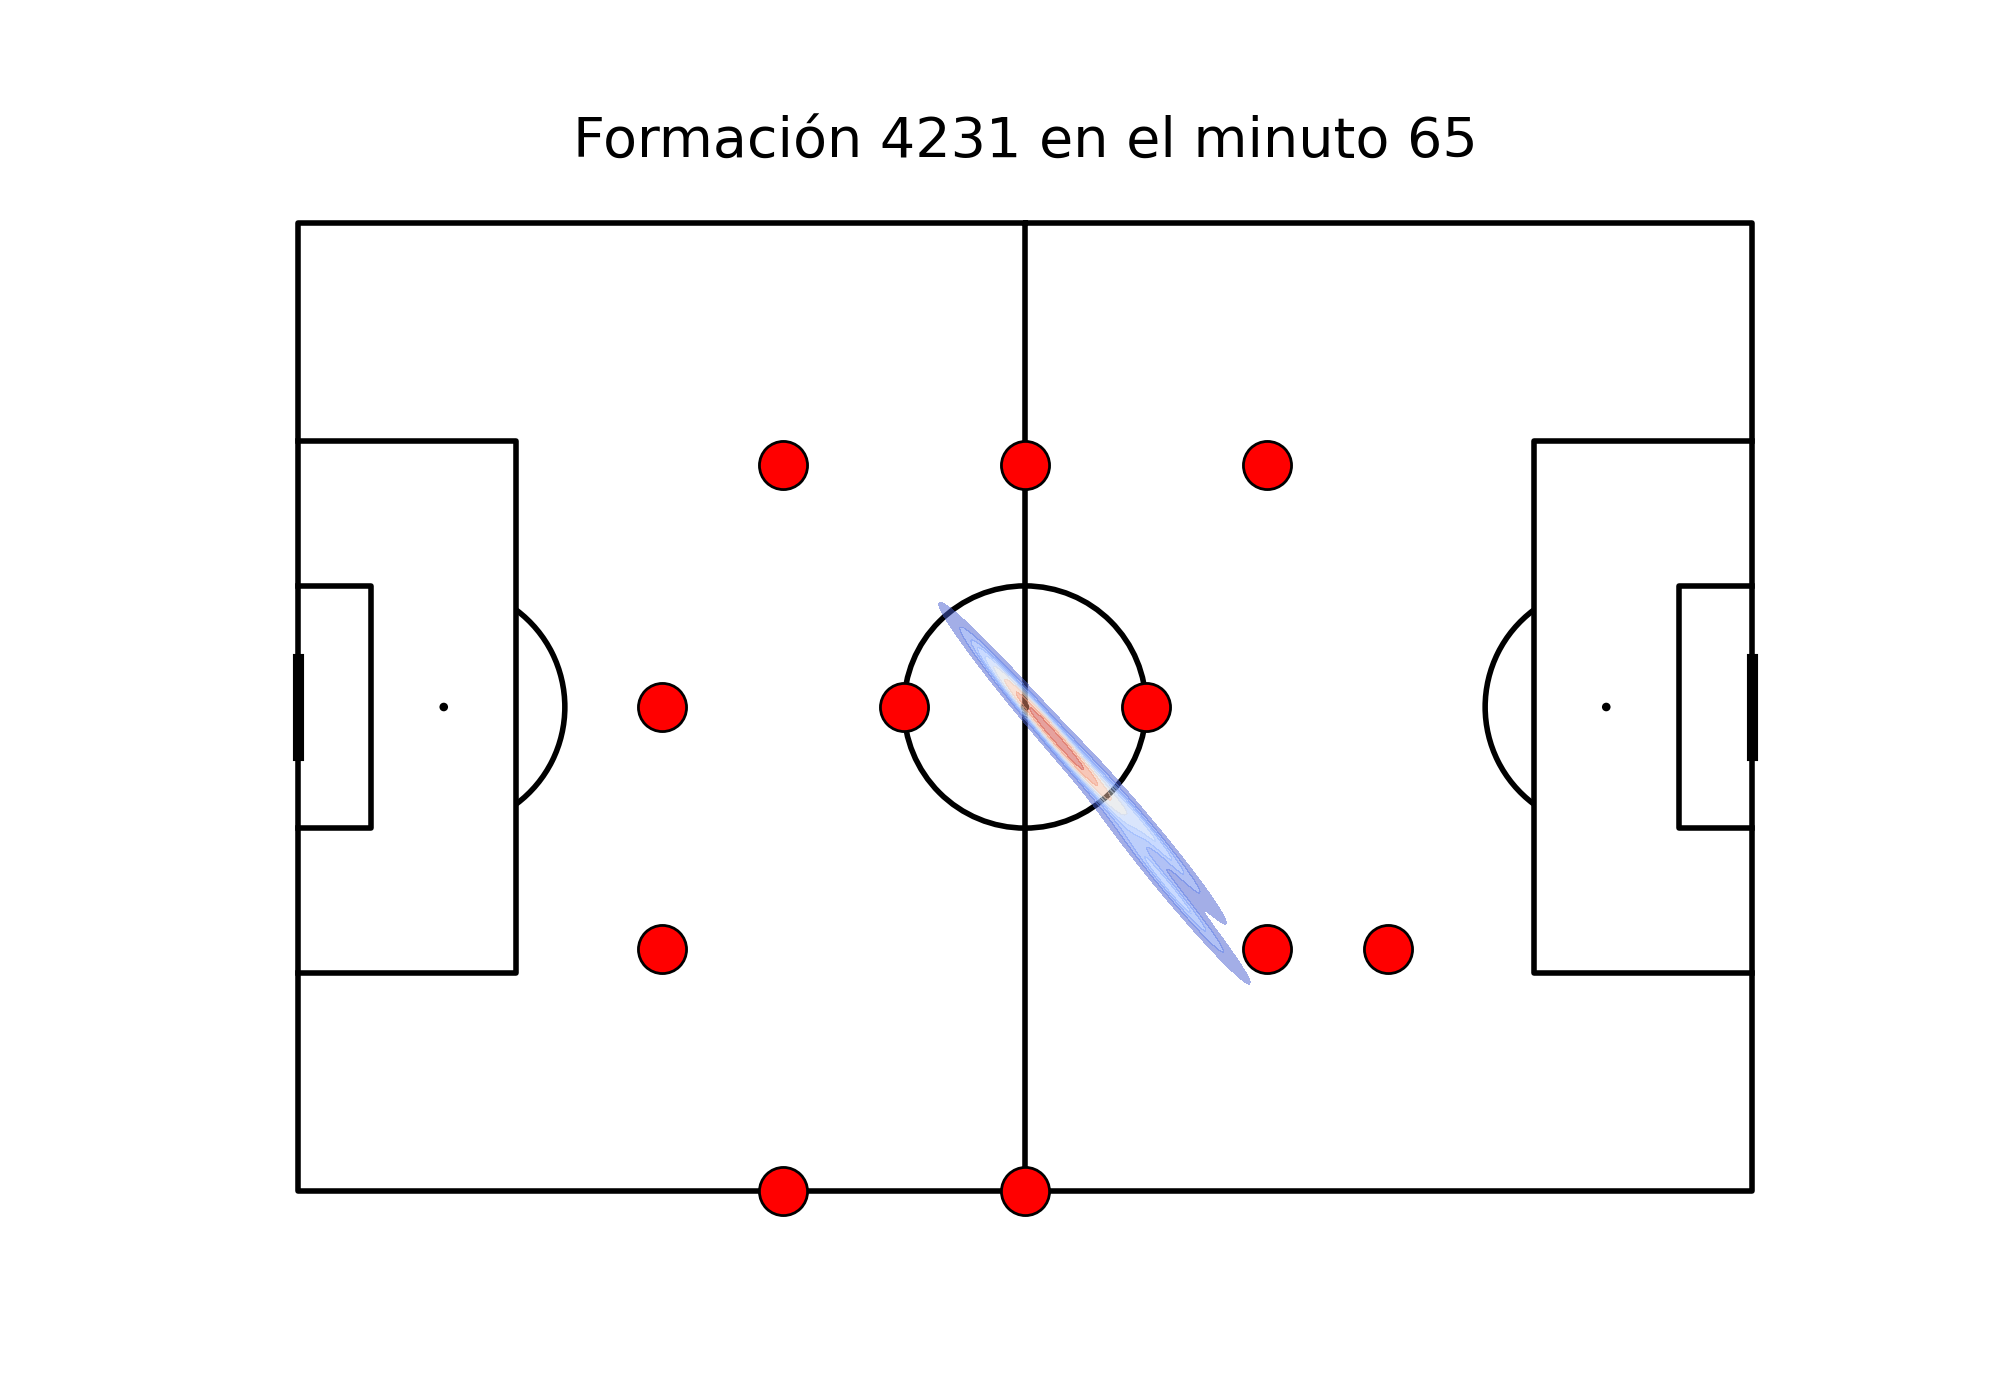

In [4]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import seaborn as sns
from matplotlib.animation import FuncAnimation
import numpy as np

# Definir los cambios de formación y los minutos en los que ocurren
formaciones = [
    (4231, 65),
    (4231, 83),
    (442, 93),
    (352, 90),
    (343, 105)
]

# Crear una lista simulada de posiciones de jugadores para cada formación
posiciones_formaciones = {
    4231: [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (60, 20), (40, 20), (80, 20)],
    442:  [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (50, 20), (70, 20)],
    352:  [(20, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (60, 20), (40, 20), (80, 20)],
    343:  [(20, 60), (40, 80), (60, 80), (80, 60), (50, 50), (30, 40), (70, 40), (60, 20), (50, 30), (40, 20), (80, 20)]
}

# Simulamos eventos de ataque del equipo contrario, que representan las zonas vulnerables del equipo en cada intervalo
# Estos eventos pueden ser pases, tiros, etc., que el equipo contrario realiza.
eventos_zonas_vulnerables = [
    np.array([[60, 40], [62, 42], [63, 43], [70, 50], [65, 45], [72, 55]]),  # Intervalo para formación 4231
    np.array([[75, 35], [77, 37], [73, 33], [80, 40], [70, 30], [85, 45]]),  # Intervalo para formación 4231
    np.array([[78, 38], [79, 39], [82, 40], [85, 45], [80, 50], [75, 35]]),  # Intervalo para formación 442
    np.array([[90, 60], [88, 62], [85, 55], [92, 58], [86, 50], [95, 65]]),  # Intervalo para formación 352
    np.array([[60, 50], [70, 60], [80, 70], [60, 40], [90, 65], [80, 55]])   # Intervalo para formación 343
]

# Crear el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Función para dibujar cada cuadro de la animación
def actualizar_formacion(frame):
    ax.clear()  # Limpiar el eje para cada nueva formación
    pitch.draw(ax=ax)  # Redibujar el campo
    
    # Dibujar la alineación del equipo
    formacion, minuto = formaciones[frame]  # Obtener la formación y el minuto actual
    posiciones = posiciones_formaciones[formacion]  # Obtener las posiciones para la formación
    
    # Dibujar los jugadores en sus posiciones
    for pos in posiciones:
        ax.scatter(pos[0], pos[1], color='red', s=300, edgecolors='black', zorder=5)
    
    # Añadir un título con la formación y el minuto
    ax.set_title(f"Formación {formacion} en el minuto {minuto}", fontsize=20)
    
    # Crear el mapa de calor de las zonas vulnerables (eventos del equipo contrario)
    eventos_vulnerables = eventos_zonas_vulnerables[frame]  # Obtener eventos del intervalo actual
    sns.kdeplot(
        x=eventos_vulnerables[:, 0], 
        y=eventos_vulnerables[:, 1], 
        shade=True, 
        cmap='coolwarm', 
        ax=ax, 
        alpha=0.5, 
        zorder=4
    )

# Crear la animación con repetición infinita
anim = FuncAnimation(fig, actualizar_formacion, frames=len(formaciones), interval=2000, repeat=True)

# Mostrar la animación
plt.show()


<IPython.core.display.Javascript object>


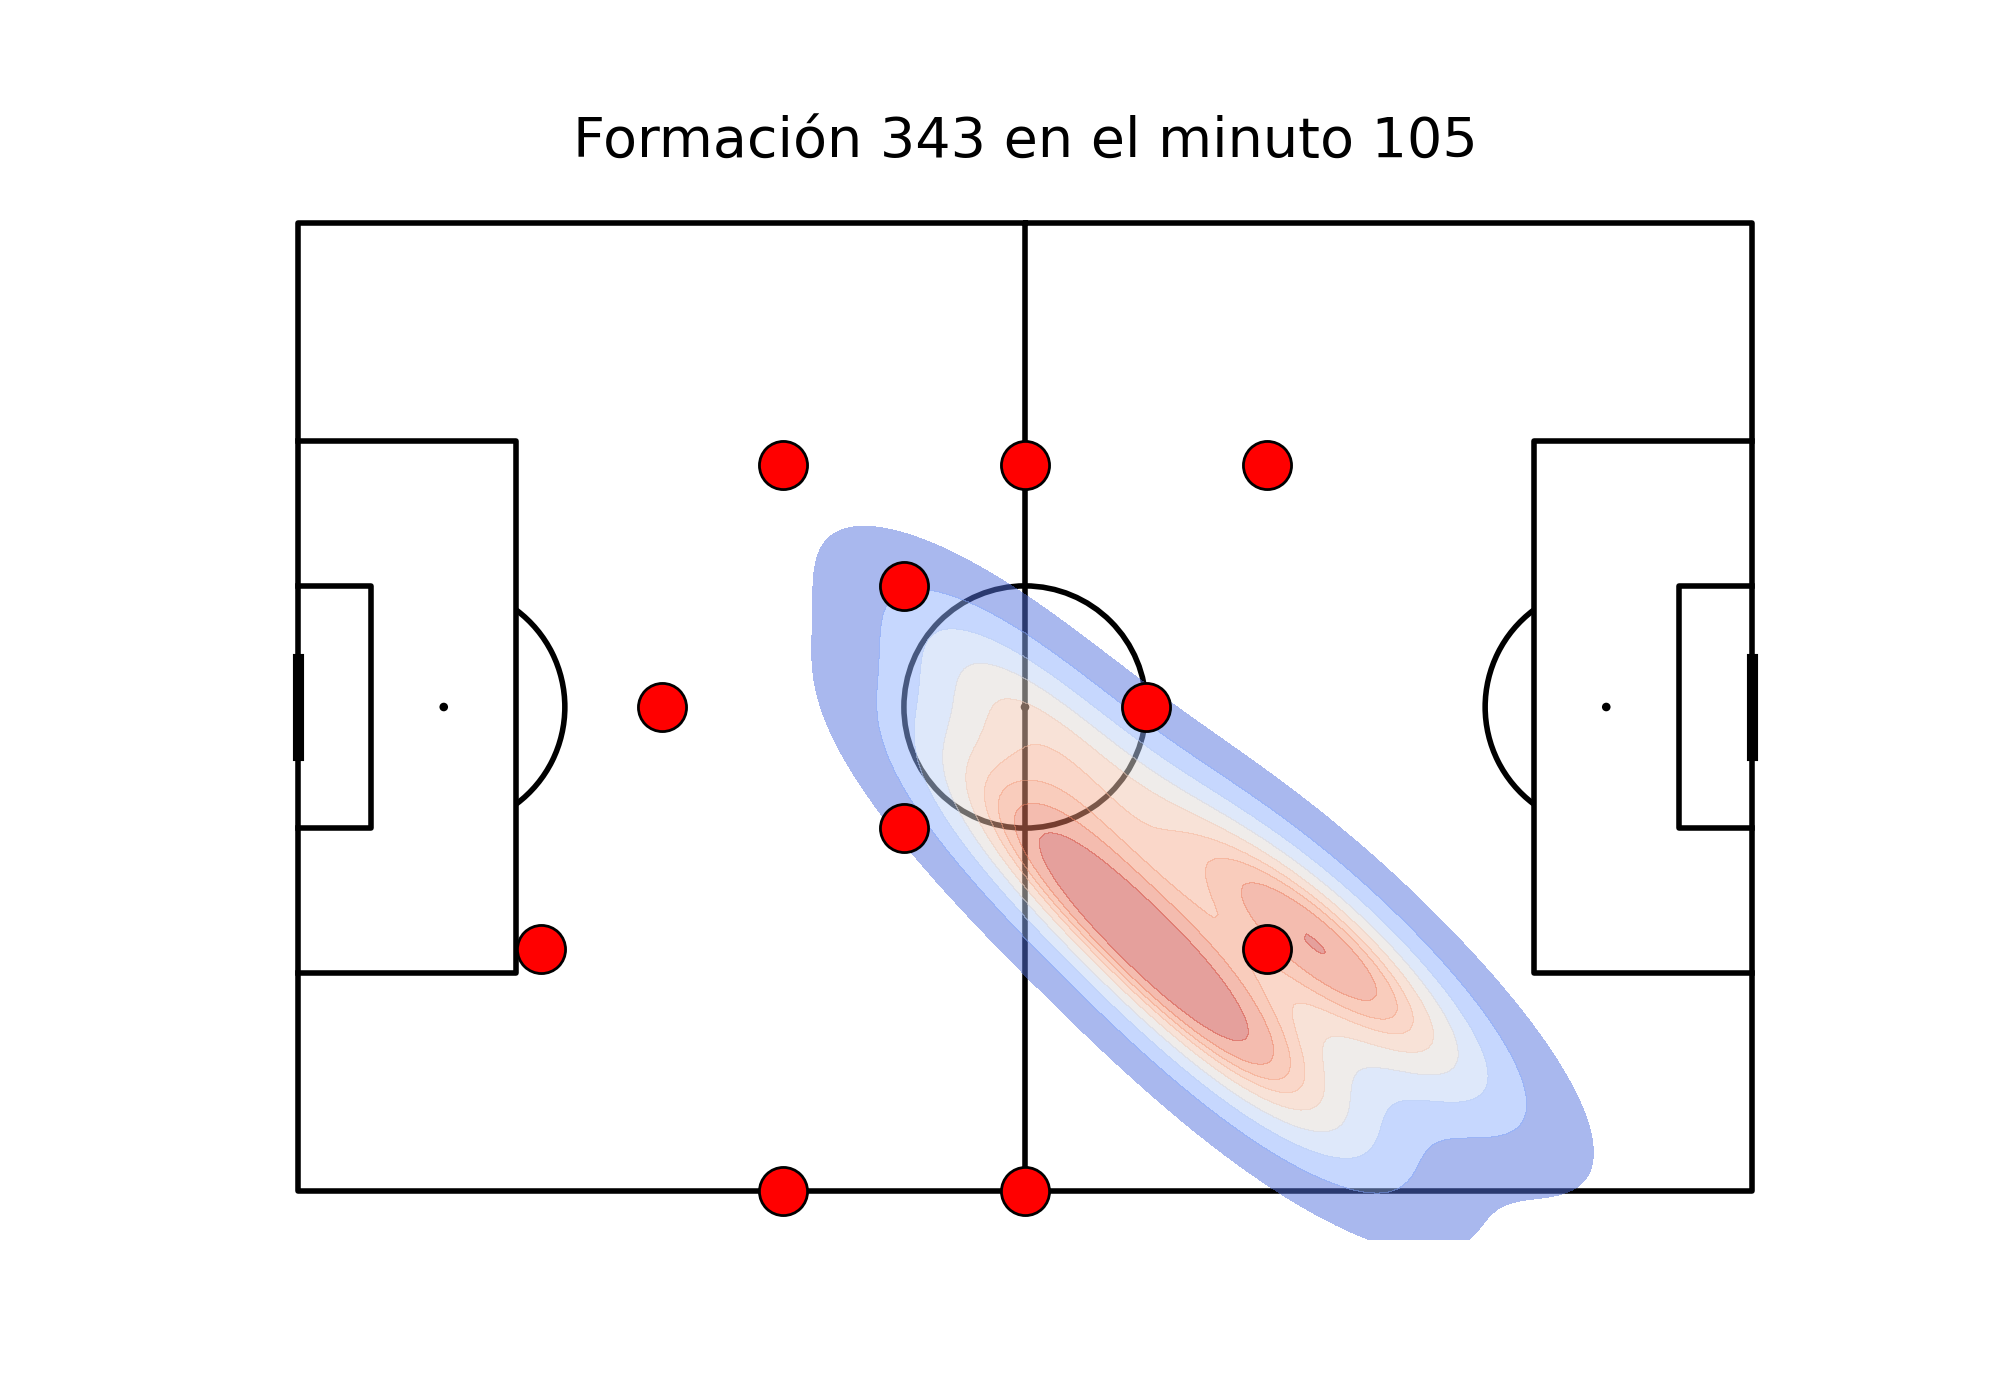

In [7]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import seaborn as sns
from matplotlib.animation import FuncAnimation
import numpy as np

# Definir los cambios de formación y los minutos en los que ocurren
formaciones = [
    (4231, 65),
    (4231, 83),
    (442, 93),
    (352, 90),
    (343, 105)
]

# Crear una lista simulada de posiciones de jugadores para cada formación
posiciones_formaciones = {
    4231: [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (60, 20), (40, 20), (80, 20)],
    442:  [(30, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (90, 60), (50, 20), (70, 20)],
    352:  [(20, 60), (40, 80), (60, 80), (80, 60), (30, 40), (50, 40), (70, 40), (60, 20), (40, 20), (80, 20)],
    343:  [(20, 60), (40, 80), (60, 80), (80, 60), (50, 50), (30, 40), (70, 40), (60, 20), (50, 30), (40, 20), (80, 20)]
}

# Simulamos eventos de ataque del equipo contrario, que representan las zonas vulnerables del equipo en cada intervalo
eventos_zonas_vulnerables = [
    np.array([[60, 40], [62, 42], [63, 43], [70, 50], [65, 45], [72, 55]]),
    np.array([[75, 35], [77, 37], [73, 33], [80, 40], [70, 30], [85, 45]]),
    np.array([[78, 38], [79, 39], [82, 40], [85, 45], [80, 50], [75, 35]]),
    np.array([[90, 60], [88, 62], [85, 55], [92, 58], [86, 50], [95, 65]]),
    np.array([[60, 50], [70, 60], [80, 70], [60, 40], [90, 65], [80, 55]])
]

# Crear el campo de fútbol
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = plt.subplots(figsize=(10, 7))
pitch.draw(ax=ax)

# Función para dibujar cada cuadro de la animación
def actualizar_formacion(frame):
    ax.clear()  # Limpiar el eje para cada nueva formación
    pitch.draw(ax=ax)  # Redibujar el campo
    
    # Dibujar la alineación del equipo
    formacion, minuto = formaciones[frame]  # Obtener la formación y el minuto actual
    posiciones = posiciones_formaciones[formacion]  # Obtener las posiciones para la formación
    
    # Dibujar los jugadores en sus posiciones
    for pos in posiciones:
        ax.scatter(pos[0], pos[1], color='red', s=300, edgecolors='black', zorder=5)
    
    # Añadir un título con la formación y el minuto
    ax.set_title(f"Formación {formacion} en el minuto {minuto}", fontsize=20)
    
    # Crear el mapa de calor de las zonas vulnerables (eventos del equipo contrario)
    eventos_vulnerables = eventos_zonas_vulnerables[frame]  # Obtener eventos del intervalo actual
    sns.kdeplot(
        x=eventos_vulnerables[:, 0], 
        y=eventos_vulnerables[:, 1], 
        shade=True, 
        cmap='coolwarm', 
        ax=ax, 
        alpha=0.5, 
        zorder=4
    )
    
    # Agregar una marca de agua en el centro del campo
    ax.text(60, 40, 'No hubo goles', fontsize=50, color='gray', alpha=0.3, ha='center', va='center', rotation=30)

# Crear la animación con repetición infinita
anim = FuncAnimation(fig, actualizar_formacion, frames=len(formaciones), interval=2000, repeat=True)

# Mostrar la animación
plt.show()


In [9]:
from statsbombpy import sb

# Obtener todos los partidos del torneo Euro 2024
partidos_euro_2024 = sb.matches(competition_id=55, season_id=282)

# Función para verificar cambios de jugadores en el primer y segundo tiempo
def verificar_cambios_jugadores(match_id):
    # Obtener los eventos del partido
    eventos = sb.events(match_id=match_id)
    
    # Filtrar los eventos de sustituciones (Substitution)
    sustituciones = eventos[eventos['type'] == 'Substitution']
    
    # Separar sustituciones por primer y segundo tiempo
    sustituciones_primer_tiempo = sustituciones[sustituciones['period'] == 1]
    sustituciones_segundo_tiempo = sustituciones[sustituciones['period'] == 2]
    
    cambios_primer_tiempo = []
    cambios_segundo_tiempo = []

    # Extraer jugadores que entraron y salieron en el primer tiempo
    for index, row in sustituciones_primer_tiempo.iterrows():
        try:
            jugador_entrante = row['substitution_replacement']['name']
            jugador_saliente = row['player']['name']
            minuto = row['minute']
            cambios_primer_tiempo.append((jugador_saliente, jugador_entrante, minuto))
        except (TypeError, KeyError):
            print(f"Error procesando sustitución en el primer tiempo para el match_id {match_id}")

    # Extraer jugadores que entraron y salieron en el segundo tiempo
    for index, row in sustituciones_segundo_tiempo.iterrows():
        try:
            jugador_entrante = row['substitution_replacement']['name']
            jugador_saliente = row['player']['name']
            minuto = row['minute']
            cambios_segundo_tiempo.append((jugador_saliente, jugador_entrante, minuto))
        except (TypeError, KeyError):
            print(f"Error procesando sustitución en el segundo tiempo para el match_id {match_id}")

    return cambios_primer_tiempo, cambios_segundo_tiempo

# Función para verificar si hubo cambios tácticos en un partido y los minutos
def verificar_cambios_tacticos_con_minutos(match_id):
    # Obtener los eventos del partido
    eventos = sb.events(match_id=match_id)
    
    # Filtrar los eventos tácticos con "Tactical Shift"
    eventos_tacticos = eventos[eventos['type'] == 'Tactical Shift']
    
    # Verificar si hay más de un evento táctico por equipo
    formaciones_por_equipo = {}
    
    for index, row in eventos_tacticos.iterrows():
        equipo = row['team']
        minuto = row['minute']  # Minuto en que ocurrió el cambio táctico
        if 'tactics' in row and 'formation' in row['tactics']:  # Verificar que la formación esté disponible
            formacion = row['tactics']['formation']  # Obtener la formación táctica
            if equipo not in formaciones_por_equipo:
                formaciones_por_equipo[equipo] = []
            formaciones_por_equipo[equipo].append((formacion, minuto))
    
    # Verificar si un equipo cambió su formación
    cambios_tacticos = {}
    for equipo, formaciones in formaciones_por_equipo.items():
        if len(set(f[0] for f in formaciones)) > 1:  # Si hay más de una formación distinta
            cambios_tacticos[equipo] = formaciones
    
    return cambios_tacticos

# Recorrer todos los partidos y verificar cambios tácticos y de jugadores
resultados_cambios = []

for index, partido in partidos_euro_2024.iterrows():
    match_id = partido['match_id']
    home_team = partido['home_team']
    away_team = partido['away_team']
    
    # Verificar cambios de jugadores
    cambios_primer_tiempo, cambios_segundo_tiempo = verificar_cambios_jugadores(match_id)
    
    # Verificar cambios tácticos
    cambios_tacticos = verificar_cambios_tacticos_con_minutos(match_id)
    
    if cambios_primer_tiempo or cambios_segundo_tiempo or cambios_tacticos:
        resultados_cambios.append({
            'match_id': match_id,
            'home_team': home_team,
            'away_team': away_team,
            'cambios_primer_tiempo': cambios_primer_tiempo,
            'cambios_segundo_tiempo': cambios_segundo_tiempo,
            'cambios_tacticos': cambios_tacticos
        })

# Mostrar los resultados con los cambios tácticos y de jugadores
for resultado in resultados_cambios:
    print(f"Match ID: {resultado['match_id']}")
    print(f"Partido: {resultado['home_team']} vs {resultado['away_team']}")
    
    # Mostrar cambios tácticos
    if resultado['cambios_tacticos']:
        print("  Cambios tácticos:")
        for equipo, formaciones in resultado['cambios_tacticos'].items():
            print(f"  Equipo: {equipo}")
            print(f"  Formaciones durante el partido y sus minutos:")
            for formacion, minuto in formaciones:
                print(f"    Formación: {formacion} en el minuto {minuto}")
        print("  Hubo cambios en la alineación táctica")
    
    # Mostrar cambios de jugadores en el primer tiempo
    if resultado['cambios_primer_tiempo']:
        print("  Cambios en el primer tiempo:")
        for saliente, entrante, minuto in resultado['cambios_primer_tiempo']:
            print(f"    Jugador salido: {saliente}, Jugador entrante: {entrante}, Minuto: {minuto}")
    
    # Mostrar cambios de jugadores en el segundo tiempo
    if resultado['cambios_segundo_tiempo']:
        print("  Cambios en el segundo tiempo:")
        for saliente, entrante, minuto in resultado['cambios_segundo_tiempo']:
            print(f"    Jugador salido: {saliente}, Jugador entrante: {entrante}, Minuto: {minuto}")
    
    print("-" * 40)


Error procesando sustitución en el primer tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3942819
Error procesando sustitución en el segundo tiempo para el match_id 3943043
Error procesando sustitución en el segundo tiempo para el match_id 3943043
Error procesando sustitución en el segundo tiempo para el match_id 3943043
Error procesando sustitución en el segundo tiempo para el match_id 3943043
Error procesando sustituci

KeyboardInterrupt: 